In [173]:
# Standard lib imports
import random
from typing import Union, Tuple, Callable, Any

# Third party imports
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
DATA_PATH = '../data/telco.csv'

In [3]:
df_churn = pd.read_csv(DATA_PATH)
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
def string_transformations(
    target: Union[pd.core.strings.accessor.StringMethods, pd.core.indexes.base.Index]
) -> Union[pd.core.series.Series, pd.core.indexes.base.Index]:
    """
        Stage 1 cleaning for this churn prediction:
        - Lower case for everything
        - Spaces replaced by underscores

        Can work on either Pandas indices (e.g. column headers) or Pandas series (e.g. row data)
        
        :param StringMethods | Index target: the target row or column to standardise
        :return StringMethods | Index result: the standardised row or column

        Note the return types are using typing since this was written pre-3.10.
    """
    result = (
        target
        .str
        .lower()
        .str
        .replace(' ', '_')
    )

    return result

In [5]:
# Fix lack of consistency in columns
def standardise_strings(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    df_new.columns = string_transformations(target=df_new.columns)

    object_filter = df_new.dtypes == type(object)

    categorical_columns = list(df_new.dtypes[object_filter].index)
    df_new[categorical_columns] = df_new[categorical_columns].apply(func=string_transformations, axis=1)
    return df_new

def standardise_float(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    new_col = pd.to_numeric(df[col_name], errors='coerce')

    df_new = df.copy()
    df_new[col_name] = new_col.fillna(0)

    return df_new

def encode_labels(df: pd.DataFrame, col_name: str, encode_value: str) -> pd.DataFrame:
    new_col = (df[col_name] == encode_value).astype(int)

    df_new = df.copy()
    df_new[col_name] = new_col

    return df_new

In [6]:
df_churn_standardised = standardise_strings(df_churn)
df_fixed_charges = standardise_float(df=df_churn_standardised, col_name='totalcharges')
df_encoded_labels = encode_labels(df=df_fixed_charges, col_name='churn', encode_value='yes')

In [7]:
# Using scikit-learn - no need to write this custom anymore like in the other follow-along!
df_full_train, df_test = train_test_split(df_encoded_labels, test_size=0.2, random_state=1)

# But this splits into just train (80%) and test (20%). This needs another split for validation component.
# To split the training set again and end up with train (60%), validation (20%), test (20%)
# This requires a split of (.20/.80) = 0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Val and test should be same length
print(f"{len(df_train)=}")
print(f"{len(df_val)=}")
print(f"{len(df_test)=}")

len(df_train)=4225
len(df_val)=1409
len(df_test)=1409


In [8]:
# Time to set up these dataframes for testing/training/validation
# Sort them and separate out the desired label (churn)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numeric_variables = ['tenure', 'monthlycharges', 'totalcharges']
categorical_variables = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [10]:
def train_model(df: pd.DataFrame, categorical_variables: list[str], numeric_variables: list[str], y_train: pd.Series) -> Tuple[LogisticRegression, DictVectorizer]:
    dict_df = df[categorical_variables + numeric_variables].to_dict(orient="records")
    vectorizer = DictVectorizer(sparse=False)
    X_train = vectorizer.fit_transform(dict_df)
    print(f"{X_train.shape=}")

    model = LogisticRegression()
    model.fit(X_train, y_train)

    return model, vectorizer

In [11]:
# # Skipped ahead to the training/use of this model - no need for all the EDA in previous notebook
# # Maybe turn this into a function to get the "final" model
# dict_full_train = df_full_train[categorical_variables + numeric_variables].to_dict(orient="records")
# full_vectorizer = DictVectorizer(sparse=False)
# X_full_train = full_vectorizer.fit_transform(dict_full_train)
# y_full_train = df_full_train.churn.values

# final_model = LogisticRegression()
# final_model.fit(X_full_train, y_full_train)

# dicts_test = df_test[categorical_variables + numeric_variables].to_dict(orient="records")
# X_test = full_vectorizer.transform(dicts_test)

# y_test_pred = final_model.predict_proba(X_test)[:, 1]
# churn_decision = (y_test_pred > 0.5)

# (churn_decision == y_test).mean()

In [12]:
model, full_vectorizer = train_model(df=df_train, categorical_variables=categorical_variables, numeric_variables=numeric_variables, y_train=y_train)

dict_val = df_val[categorical_variables + numeric_variables].to_dict(orient="records")
dict_test = df_test[categorical_variables + numeric_variables].to_dict(orient="records")
X_val = full_vectorizer.transform(dict_val)
X_test = full_vectorizer.transform(dict_test)
y_val_pred = model.predict_proba(X_val)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]
churn_decision = (y_val_pred > 0.5)
(y_val == churn_decision).mean()

X_train.shape=(4225, 45)


0.8034066713981547

#### Evaluating Model Accuracy

[0.2739531582682754, 0.5088715400993612, 0.5911994322214337, 0.6664300922640171, 0.7097232079489, 0.7388218594748048, 0.7601135557132718, 0.7721788502484032, 0.7849538679914834, 0.7934705464868701, 0.8034066713981547, 0.801277501774308, 0.794889992902768, 0.7863733144073811, 0.765791341376863, 0.7444996451383961, 0.7345635202271115, 0.7260468417317246, 0.7260468417317246, 0.7260468417317246, 0.7260468417317246]


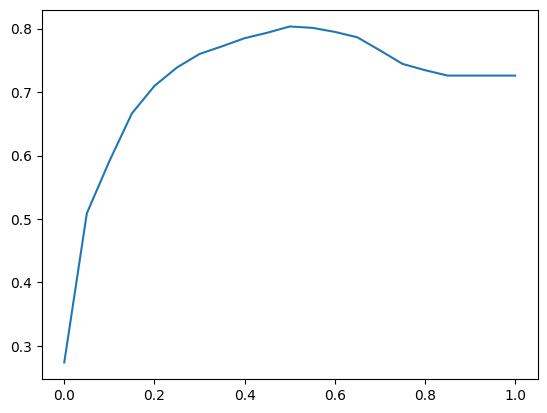

In [13]:
thresholds = np.linspace(0, 1, 21)
test = thresholds[0]

def check_threshold(y_val: np.ndarray, y_pred: np.ndarray, threshold: float):
    return accuracy_score(y_val, y_pred >= threshold)

threshold_scores = [check_threshold(y_val=y_val, y_pred=y_val_pred, threshold=threshold) for threshold in thresholds]
print(threshold_scores)
plt.plot(thresholds, threshold_scores)

In [14]:
# So it turns out 0.5 was the right churn decision threshold to pick.
# Also turns out (y_pred == churn_decision).mean() has a built-in sklearn equivalent
accuracy_score(y_val, y_val_pred >= 0.5)

0.8034066713981547

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

threshold = 0.5
predict_positive = (y_val_pred >= threshold)
predict_negative = (y_val_pred < threshold)

In [16]:
results_true_positive = (predict_positive & actual_positive).sum()
results_true_negative = (predict_negative & actual_negative).sum()
results_false_positive = (predict_positive & actual_negative).sum()
results_false_negative = (predict_negative & actual_positive).sum()

results_true_positive, results_true_negative, results_false_negative, results_false_positive

(210, 922, 176, 101)

In [17]:
confusion_matrix = np.array([
    [results_true_negative, results_false_positive],
    [results_false_negative, results_true_positive]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [18]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [19]:
accuracy_score = (
        (results_true_positive + results_true_negative) / 
        (results_true_positive + results_true_negative + results_false_positive + results_false_negative)
)

In [20]:
# Fraction of positive predictions that were actually correct
# So of all positives, how many were right?
precision = (
    results_true_positive /
    (results_true_positive + results_false_positive)
)

# Fraction of correctly identified positive examples
# So of all actual churns, how many were picked up?
recall = (
    results_true_positive /
    (results_true_positive + results_false_negative)
)

# So the model's not amazing even with 80% "accuracy score"
# In reality, it failed to identify nearly 46% of actual churning customers
(precision * 100).round(2), (recall * 100).round(2)

(67.52, 54.4)

In [21]:
# ROC/AUC
rate_true_positive = results_true_positive / (results_true_positive + results_false_negative)
rate_false_positive = results_false_positive / (results_false_positive + results_true_negative)

f"{rate_true_positive=}", f"{rate_false_positive=}", f"{recall=}", f"{precision=}"

('rate_true_positive=0.5440414507772021',
 'rate_false_positive=0.09872922776148582',
 'recall=0.5440414507772021',
 'precision=0.6752411575562701')

In [55]:
thresholds = np.linspace(0, 1, 101)

def calc_confusion_matrix(y_val: np.ndarray, y_pred: np.ndarray, threshold: float) -> Tuple[float, float, float, float, float]:
    actual_pos = (y_val == 1) 
    actual_neg = (y_val == 0)

    predict_pos = (y_pred >= threshold)
    predict_neg = (y_pred < threshold)

    true_pos = (predict_pos & actual_pos).sum()
    true_neg = (predict_neg & actual_neg).sum()

    false_pos = (predict_pos & actual_neg).sum() 
    false_neg = (predict_neg & actual_pos).sum()

    return (threshold, true_pos, false_pos, false_neg, true_neg)

scores = [calc_confusion_matrix(y_val=y_val, y_pred=y_val_pred, threshold=t) for t in thresholds]
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 303, 70, 720),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [47]:
score_columns = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']
df_scores = pd.DataFrame(scores, columns=score_columns)

df_scores['true_positive_rate'] = df_scores['true_positive'] / (df_scores['true_positive'] + df_scores['false_negative'])
df_scores['false_positive_rate'] = df_scores['false_positive'] / (df_scores['false_positive'] + df_scores['true_negative'])
df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,true_positive_rate,false_positive_rate
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


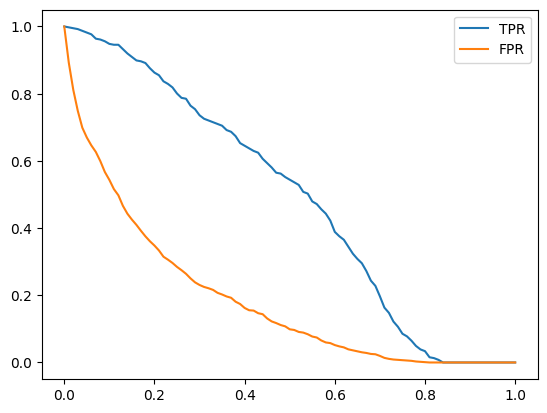

In [32]:
plt.plot(df_scores['threshold'], df_scores['true_positive_rate'], label='TPR')
plt.plot(df_scores['threshold'], df_scores['false_positive_rate'], label='FPR')
plt.legend()

In [37]:
# Create random churn predictions!
np.random.seed(1)
y_random = np.random.uniform(0, 1, size=len(y_val))
y_random.round(3)
((y_random >= 0.05) == y_val).mean()

0.3016323633782825

In [53]:
def plot_threshold_scores(df_scores: pd.DataFrame):
    plt.plot(df_scores['threshold'], df_scores['true_positive_rate'], label='TPR')
    plt.plot(df_scores['threshold'], df_scores['false_positive_rate'], label='FPR')
    plt.legend()

def create_threshold_scores(scores: list[Tuple[float, float, float, float, float]]) -> pd.DataFrame:
    score_columns = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']
    df_scores = pd.DataFrame(scores, columns=score_columns)

    df_scores['true_positive_rate'] = df_scores['true_positive'] / (df_scores['true_positive'] + df_scores['false_negative'])
    df_scores['false_positive_rate'] = df_scores['false_positive'] / (df_scores['false_positive'] + df_scores['true_negative'])

    return df_scores

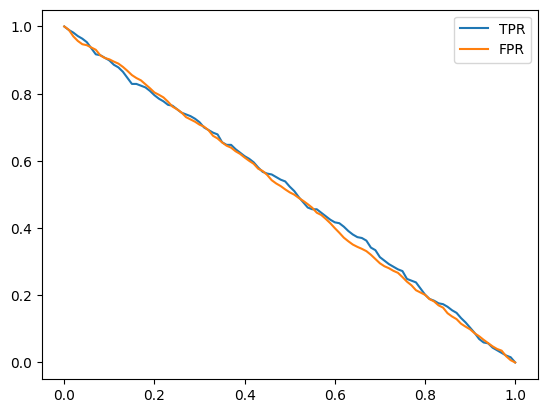

In [58]:
scores_random = [calc_confusion_matrix(y_val, y_random, threshold=t) for t in thresholds]
df_scores_random = create_threshold_scores(scores_random)
plot_threshold_scores(df_scores_random)

In [60]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1023, 386)

In [61]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [65]:
y_ideal_pred = np.linspace(0, 1, len(y_ideal))
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

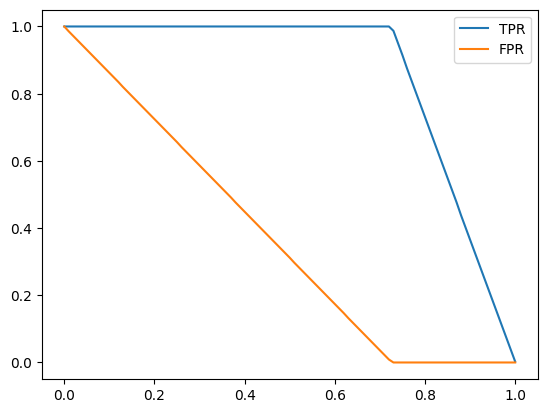

In [67]:
scores_ideal = [calc_confusion_matrix(y_ideal, y_ideal_pred, threshold=t) for t in thresholds]
df_scores_ideal = create_threshold_scores(scores_ideal)
plot_threshold_scores(df_scores_ideal)

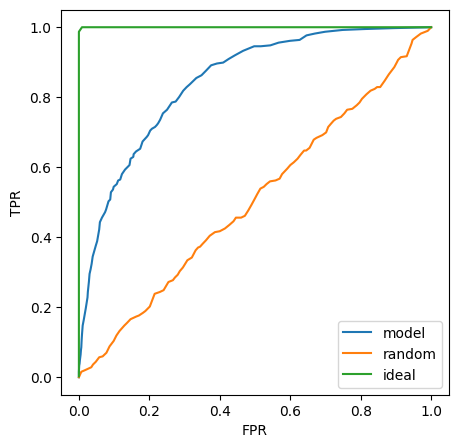

In [70]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores['false_positive_rate'], df_scores['true_positive_rate'], label='model')
plt.plot(df_scores_random['false_positive_rate'], df_scores_random['true_positive_rate'], label='random')
plt.plot(df_scores_ideal['false_positive_rate'], df_scores_ideal['true_positive_rate'], label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [73]:
# Time to do it all again with sklearn
fp_rate, tp_rate, roc_thresholds = roc_curve(y_val, y_val_pred)

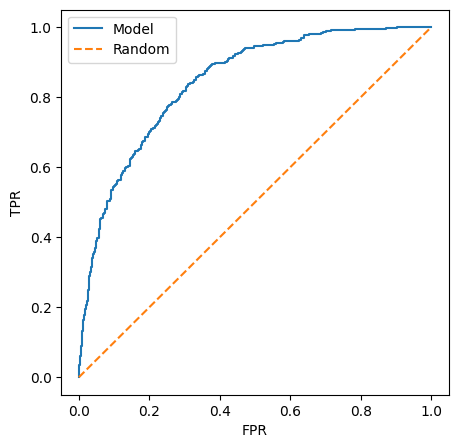

In [75]:
plt.figure(figsize=(5, 5))

plt.plot(fp_rate, tp_rate, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

In [80]:
roc_auc_score(y_val, y_val_pred)

0.8438505057258191

In [81]:
neg_pred = y_val_pred[y_val == 0]
pos_pred = y_val_pred[y_val == 1]

In [90]:
pos_idx = random.randint(0, len(pos_pred) - 1)
neg_idx = random.randint(0, len(neg_pred) - 1)

pos_idx, neg_idx

(325, 988)

In [96]:
def random_select_predictions(neg_pred: np.ndarray, pos_pred: np.ndarray) -> Tuple[float, float, bool]:
    pos_idx = random.randint(0, len(pos_pred) - 1)
    neg_idx = random.randint(0, len(neg_pred) - 1)

    pos_result = pos_pred[pos_idx]
    neg_result = neg_pred[neg_idx]

    return pos_result, neg_result, pos_result > neg_result

random_selection_results = [random_select_predictions(neg_pred=neg_pred, pos_pred=pos_pred) for x in range(10000)]

(0.596893665039837, 0.017713893416182902, True)

In [125]:
res = sum([x[2] for x in random_selection_results]) / 10000
res

0.8366

#### Cross-Fold Validation

In [166]:
def train(df: pd.DataFrame, y_train: np.ndarray, categorical: list[str], numerical: list[str], regularization_factor: float = 1.0) -> Tuple[DictVectorizer, LogisticRegression]:
    dict_train: dict = df[categorical + numerical].to_dict(orient="records")

    vect = DictVectorizer(sparse=False)
    X_train = vect.fit_transform(dict_train)

    model = LogisticRegression(C=regularization_factor, max_iter=1000)
    model.fit(X_train, y_train)

    return vect, model

def predict(df: pd.DataFrame, vect: DictVectorizer, model: LogisticRegression, categorical: list[str], numerical: list[str]) -> np.ndarray:
    dict_predict: dict = df[categorical + numerical].to_dict(orient="records")

    X = vect.transform(dict_predict)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [167]:
vct, mdl = train(df=df_train, y_train=y_train, categorical=categorical_variables, numerical=numeric_variables, regularization_factor=0.001)

In [168]:
y_fold_pred = predict(df=df_val, vect=vct, model=mdl, categorical=categorical_variables, numerical=numeric_variables)
y_fold_pred

array([0.00788893, 0.20792945, 0.22184962, ..., 0.15069905, 0.77673727,
       0.81028563])

In [178]:
n_splits: int = 5

for next_reg_factor in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    k_fold = KFold(n_splits=10, shuffle=True, random_state=1)

    for train_idx, val_idx in tqdm(k_fold.split(df_full_train), total=n_splits):
        df_train_next = df_full_train.iloc[train_idx]
        df_val_next = df_full_train.iloc[val_idx]

        y_train_next = df_train_next.churn.values
        y_val_next = df_val_next.churn.values

        vct_next, mdl_next = train(df=df_train_next, y_train=y_train_next, categorical=categorical_variables, numerical=numeric_variables, regularization_factor=next_reg_factor)
        y_pred_next = predict(df=df_val_next, vect=vct_next, model=mdl_next, categorical=categorical_variables, numerical=numeric_variables)

        roc_auc_next = roc_auc_score(y_val_next, y_pred_next)
        scores.append(roc_auc_next)

    print("Regularization=%s %.3f +- %.3f" % (next_reg_factor, np.mean(scores), np.std(scores)))
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=0.001 0.826 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=0.01 0.841 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=0.1 0.841 +- 0.011


  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=0.5 0.841 +- 0.011


  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=1 0.840 +- 0.013


  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=5 0.841 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

Regularization=10 0.841 +- 0.012


In [162]:
print("AUC Scoring")
print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

AUC Scoring
0.841 +- 0.012


In [179]:
# Final model... finally
# With the winning regularization of 0.1
vct_final, mdl_final = train(df=df_full_train, y_train=df_full_train.churn.values, categorical=categorical_variables, numerical=numeric_variables, regularization_factor=0.1)
y_pred_final = predict(df=df_test, vect=vct_final, model=mdl_final, numerical=numeric_variables, categorical=categorical_variables)
auc = roc_auc_score(y_test, y_pred_final)

auc

0.8587282112949182